# Assignment 3 - Regularization & Optimization

In this assignment, you will learn how to implement:
 - two types of regularization (norm penalization and dropout)
 - advanced optimization methods that can speed up learning.

Let's first import the packages you are going to use.

In [2]:
import math
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from utils.helpers import *
from utils.testCasesRegularization import *
from utils.testCasesOptimization import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

---
## 1. Regularization

You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. They give you the following 2D dataset from France's past 10 games.

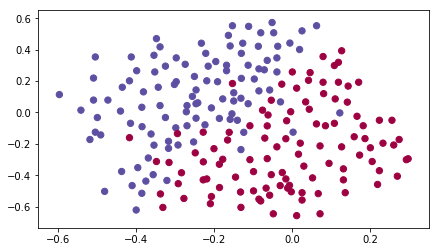

In [3]:
data = scipy.io.loadmat('utils/data.mat')
train_X = data['X'].T
train_Y = data['y'].T
test_X = data['Xval'].T
test_Y = data['yval'].T

plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.flatten(), s=40, cmap=plt.cm.Spectral);

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well. 

You will first try a non-regularized model. Then you'll learn how to regularize it and decide which model you will choose to solve the French Football Corporation's problem. 

### 1.1 Non-regularized model

You will use the following neural network, which is already implemented for you without any regularization. Then, you will implement the functions for *L2-norm penalization* and for *Dropout*. These functions are called

- in penalization mode by setting the `lambd` input to a non-zero value. 
- in dropout mode by setting the `keep_prob` to a value less than one.

In each part, you will run this model with the correct inputs, so that it calls the functions you've implemented. Take a look at the code below to familiarize yourself with the code already implemented for you.

In [4]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.163299875257242
Cost after iteration 20000: 0.13851642423257143


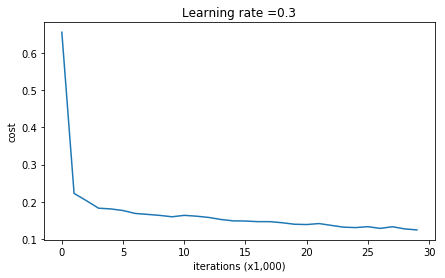

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [5]:
parameters = model(train_X, train_Y)

print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)

print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.

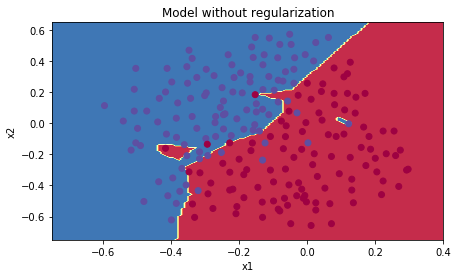

In [6]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

### 1.2 Norm penalization

The standard way to avoid overfitting consists of appropriately modifying your cost function from:

$$J = -\frac{1}{N} \sum\limits_{n = 1}^{N} \Big(\small  y^{(n)}\log\left(a^{[L](n)}\right) + (1-y^{(n)})\log\left(1- a^{[L](n)}\right) \Big) \tag{1}$$
to:
$$J_{reg} = \small \underbrace{-\frac{1}{N} \sum\limits_{n = 1}^{N} \Big(\small y^{(n)}\log\left(a^{[L](n)}\right) + (1-y^{(n)})\log\left(1- a^{[L](n)}\right) \Big) }_\text{cross-entropy cost} + \underbrace{\frac{1}{N} \frac{\lambda}{2} \sum_{l=1}^L \|W^{[l]}\|^2 }_\text{regularization cost} \tag{2}$$

Let's modify the cost and observe the consequences.

#### 1.2.1 - Forward propagation with norm penalization


**Exercise**: Implement `compute_cost_with_regularization()` which computes the cost given by the formula in (2). To calculate the squared norm of a matrix, use
```python
np.sum(np.square(W))
```
Note that you have to do this for all the layers $W^{(1)}$, $W^{(2)}$ and $W^{(3)}$, then sum the three terms and multiply by $\frac{\lambda}{2N} $.

In [21]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    L2_regularization_cost = lambd / (2 * m) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    ### END CODER HERE ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [22]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()
cost = compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)
print("cost = " + str(cost))

cost = 1.7864859451590758


**Expected Output**: 

<table> 
<tr>
<td>
**cost**
</td>
    <td>
1.78648594516
</td>
</tr>

</table> 

In [23]:
np.testing.assert_almost_equal(cost, 1.78648594516)

#### 1.2.2 - Backward propagation with norm penalization

Of course, because you changed the cost, you have to change backward propagation as well! All the gradients have to be computed with respect to this new cost. 

**Exercise**: Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient:

$$\frac{d}{dW} \Big( \frac{\lambda}{2N}  W^2 \Big) = \frac{\lambda}{N} W. $$

In [26]:
# GRADED FUNCTION: backward_propagation_with_regularization

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    ### START CODE HERE ### (approx. 3 lines)
    reg1 = lambd / m * W1
    reg2 = lambd / m * W2
    reg3 = lambd / m * W3
    ### END CODE HERE ###
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + reg3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + reg2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + reg1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [27]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


**Expected Output**:

<table> 
    <tr>
    <td>
    **dW1**
    </td>
        <td>
    [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
    </td>
    </tr>
    <tr>
    <td>
    **dW2**
    </td>
        <td>
    [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
    </td>
    </tr>
    <tr>
    <td>
    **dW3**
    </td>
        <td>
    [[-1.77691347 -0.11832879 -0.09397446]]
    </td>
    </tr>
</table> 

In [28]:
dW1 = grads["dW1"]
np.testing.assert_almost_equal(dW1[0,0], -0.25604646)
np.testing.assert_almost_equal(dW1[0,1],  0.12298827)
np.testing.assert_almost_equal(dW1[0,2], -0.28297129)
np.testing.assert_almost_equal(dW1[1,0], -0.17706303)
np.testing.assert_almost_equal(dW1[1,1],  0.34536094)
np.testing.assert_almost_equal(dW1[1,2], -0.4410571)

dW2 = grads["dW2"]
np.testing.assert_almost_equal(dW2[0,0],  0.79276486)
np.testing.assert_almost_equal(dW2[0,1],  0.85133918)
np.testing.assert_almost_equal(dW2[1,0], -0.0957219)
np.testing.assert_almost_equal(dW2[1,1], -0.01720463)
np.testing.assert_almost_equal(dW2[2,0], -0.13100772)
np.testing.assert_almost_equal(dW2[2,1], -0.03750433)

dW3 = grads["dW3"]
np.testing.assert_almost_equal(dW3[0,0], -1.77691347)
np.testing.assert_almost_equal(dW3[0,1], -0.11832879)
np.testing.assert_almost_equal(dW3[0,2], -0.09397446)

#### 1.2.3 - Test with norm penalization

Let's now run the model with L2-norm regularization $(\lambda = 0.7)$. The `model()` function will call: 
- `compute_cost_with_regularization` instead of `compute_cost`
- `backward_propagation_with_regularization` instead of `backward_propagation`

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.26809163371273004


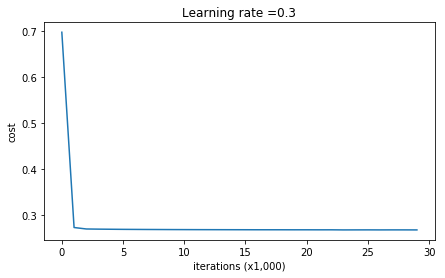

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [29]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Congrats, the test set accuracy increased to 93%. You have saved the French football team!

You are not overfitting the training data anymore. Let's plot the decision boundary.

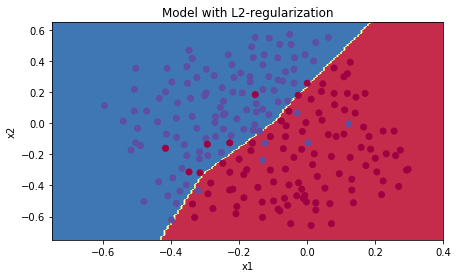

In [30]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations**
- The value of $\lambda$ is a hyperparameter that you can tune using a validation set.
- Norm penalization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

**What is norm penalization actually doing?**

L2-norm penalization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

**What you should remember about L2-norm penalization **
- A regularization term is added to the cost function
- In backpropagation, there are extra terms in the gradients with respect to weight matrices
- Weights are pushed to smaller values.

### 1.3 Dropout

Dropout is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** When you shut some neurons down, you actually modify your model. The idea behind dropout is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

#### 1.3.1 - Forward propagation with dropout

**Exercise**: Implement the forward propagation with dropout. You are using a 3 layer neural network, and will add dropout to the first and second hidden layers. We will not apply dropout to the input layer or output layer. 

**Instructions**:
You would like to shut down some neurons in the first and second layers. To do that, you are going to carry out 4 Steps:
1. Create a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using `np.random.rand()` to randomly get numbers between 0 and 1. Here, you will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 0 with probability (`1-keep_prob`) or 1 with probability (`keep_prob`), by thresholding values in $D^{[1]}$ appropriately. Hint: to set all the entries of a matrix X to 0 (if entry is less than 0.5) or 1 (if entry is more than 0.5) you would do: `X = (X < 0.5)`. Note that 0 and 1 are respectively equivalent to False and True.
3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). You can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [31]:
# GRADED FUNCTION: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # Layer 1: LINEAR -> RELU
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    ### START CODE HERE ### (approx. 4 lines)         # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                               # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                      # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob                               # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    
    # Layer 2: LINEAR -> RELU
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    ### START CODE HERE ### (approx. 4 lines)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])     # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                               # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                      # Step 3: shut down some neurons of A2
    A2 = A2 / keep_prob                               # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    
    # Layer 3: LINEAR -> SIGMOID
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [32]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


**Expected Output**: 

<table> 
<tr>
<td>
**A3**
</td>
    <td>
[[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]
</td>

</tr>

</table> 

In [33]:
np.testing.assert_almost_equal(A3[0,0], 0.36974721)
np.testing.assert_almost_equal(A3[0,1], 0.00305176)
np.testing.assert_almost_equal(A3[0,2], 0.04565099)
np.testing.assert_almost_equal(A3[0,3], 0.49683389)
np.testing.assert_almost_equal(A3[0,4], 0.36974721)

#### 1.3.2 - Backward propagation with dropout

**Exercise**: Implement the backward propagation with dropout. As before, you are training a 3 layer network. Add dropout to the first and second hidden layers, using the masks $D^{[1]}$ and $D^{[2]}$ stored in the cache. 

**Instruction**:
Backpropagation with dropout is actually quite easy. You will have to carry out 2 Steps:
1. You had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, you had divided `A1` by `keep_prob`. In backpropagation, you'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).


In [34]:
# GRADED FUNCTION: backward_propagation_with_dropout

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    ### START CODE HERE ### (≈ 2 lines of code)
    dA2 = dA2 * D2           # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob    # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    ### START CODE HERE ### (≈ 2 lines of code)
    dA1 = dA1 * D1                  # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob           # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [35]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


**Expected Output**: 

<table> 
<tr>
<td>
**dA1**
</td>
    <td>
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
[ 0.65515713  0.         -0.00337459  0.         -0.        ]]
</td>

</tr>
<tr>
<td>
**dA2**
</td>
    <td>
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
[ 0.          0.53159854 -0.          0.53159854 -0.34089673]
[ 0.          0.         -0.00292733  0.         -0.        ]]
</td>

</tr>
</table> 

In [36]:
dA1 = gradients["dA1"]
np.testing.assert_almost_equal(dA1[0,0],  0.36544439)
np.testing.assert_almost_equal(dA1[0,1],  0.0)
np.testing.assert_almost_equal(dA1[0,2], -0.00188233)
np.testing.assert_almost_equal(dA1[0,3],  0.0)
np.testing.assert_almost_equal(dA1[0,4], -0.17408748)
np.testing.assert_almost_equal(dA1[1,0],  0.65515713)
np.testing.assert_almost_equal(dA1[1,1],  0.0)
np.testing.assert_almost_equal(dA1[1,2], -0.00337459)
np.testing.assert_almost_equal(dA1[1,3],  0.0)
np.testing.assert_almost_equal(dA1[1,4],  0.0)

dA2 = gradients["dA2"]
np.testing.assert_almost_equal(dA2[0,0],  0.58180856)
np.testing.assert_almost_equal(dA2[0,1],  0.0)
np.testing.assert_almost_equal(dA2[0,2], -0.00299679)
np.testing.assert_almost_equal(dA2[0,3],  0.0)
np.testing.assert_almost_equal(dA2[0,4], -0.27715731)
np.testing.assert_almost_equal(dA2[1,0],  0.0)
np.testing.assert_almost_equal(dA2[1,1],  0.53159854)
np.testing.assert_almost_equal(dA2[1,2],  0.0)
np.testing.assert_almost_equal(dA2[1,3],  0.53159854)
np.testing.assert_almost_equal(dA2[1,4], -0.34089673)
np.testing.assert_almost_equal(dA2[2,0],  0.0)
np.testing.assert_almost_equal(dA2[2,1],  0.0)
np.testing.assert_almost_equal(dA2[2,2], -0.00292733)
np.testing.assert_almost_equal(dA2[2,3],  0.0)
np.testing.assert_almost_equal(dA2[2,4],  0.0)

### 1.3.3 - Test  with dropout

Let's now run the model with dropout (`keep_prob = 0.86`). It means at every iteration you shut down each neurons of layer 1 and 2 with 24% probability. The function `model()` will now call:
- `forward_propagation_with_dropout` instead of `forward_propagation`.
- `backward_propagation_with_dropout` instead of `backward_propagation`.

Cost after iteration 0: 0.6543912405149825


C:\Users\hosseins\Downloads\Assignment3\Assignment3\utils\helpers.py:211: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\hosseins\Downloads\Assignment3\Assignment3\utils\helpers.py:211: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.0610169865749056
Cost after iteration 20000: 0.060582435798513114


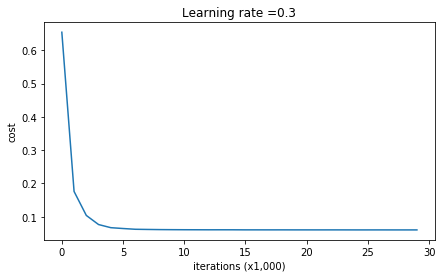

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [37]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout works great! The test accuracy has increased again (to 95%)! Your model is not overfitting the training set and does a great job on the test set. The French football team will be forever grateful to you! 

Run the code below to plot the decision boundary.

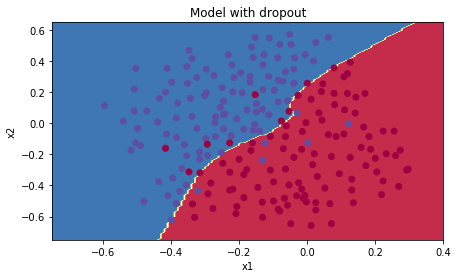

In [39]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**What you should remember about dropout**
- Dropout is a regularization technique.
- You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.  

### 1.4 What you have seen so far

Here are the results of our models: 

<table> 
<tr>
    <td>
    **model**
    </td>
    <td>
    **train accuracy**
    </td>
    <td>
    **test accuracy**
    </td>

</tr>
    <td>
    3-layer NN without regularization
    </td>
    <td>
    95%
    </td>
    <td>
    91.5%
    </td>
<tr>
    <td>
    3-layer NN with L2-regularization
    </td>
    <td>
    94%
    </td>
    <td>
    93%
    </td>
</tr>
<tr>
    <td>
    3-layer NN with dropout
    </td>
    <td>
    93%
    </td>
    <td>
    95%
    </td>
</tr>
</table> 

Note that regularization hurts training set performance! 

This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping your system. 


**What we want you to remember from this part of the notebook**
- Regularization will help you reduce overfitting.
- Regularization will drive your weights to lower values.
- L2-norm penalization and Dropout are two very effective regularization techniques.

---
## 2. Optimization

Until now, you've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, you will learn more advanced optimization methods that can speed up learning, and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days versus just a few hours to get a good result. 

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this: **minimizing the cost is like finding the lowest point in a hilly landscape.**

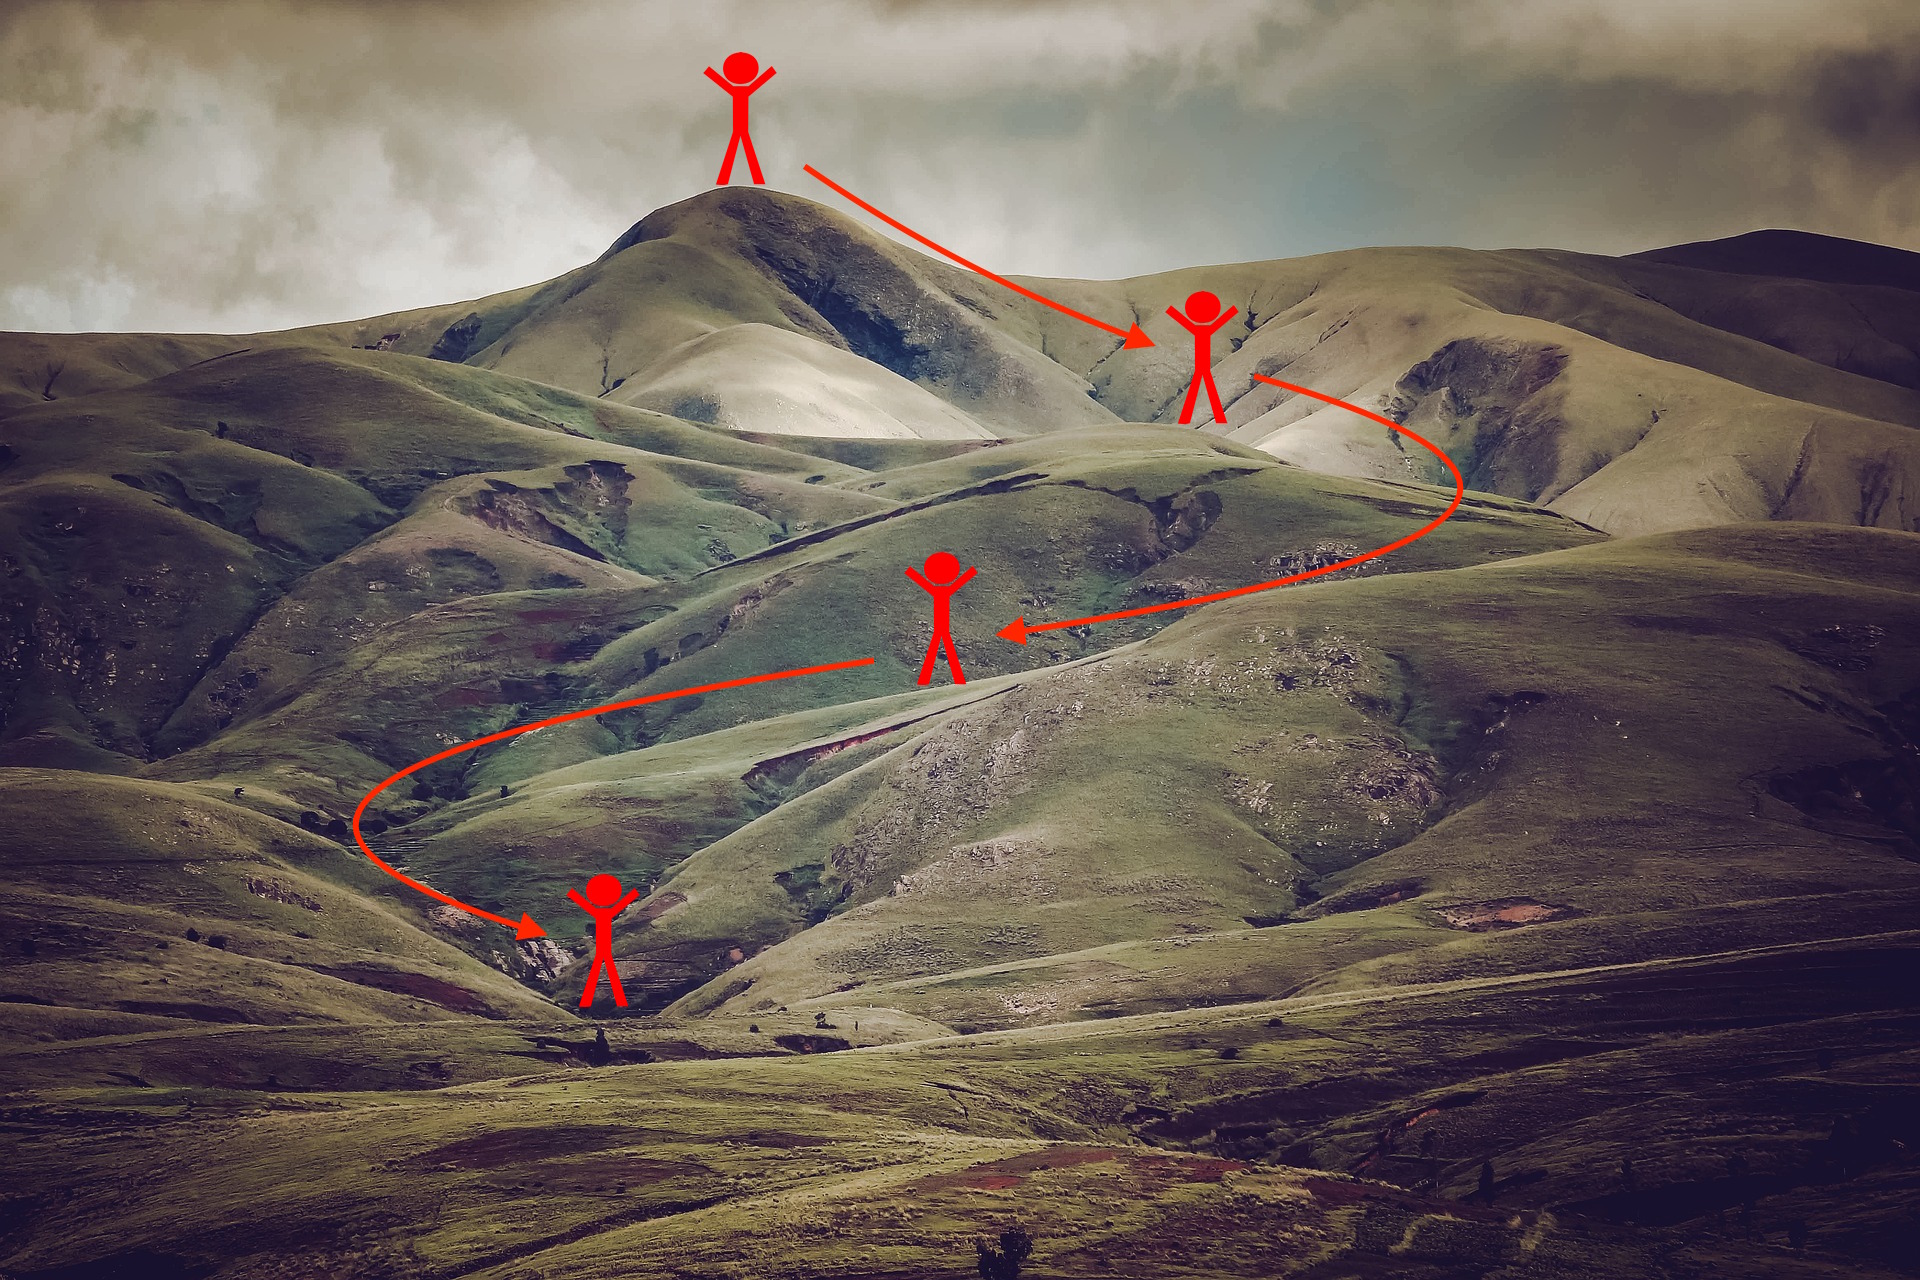

**Notations**: As usual, $\frac{\partial J}{\partial a } = $ `da` for any variable `a`.

### 2.1 Gradient descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent. 

**Warm-up exercise**: Implement the gradient descent update rule. The  gradient descent rule is, for $l = 1, ..., L$: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$

$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

where L is the number of layers and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.

**Remark:** The iterator `l` starts at 0 in the for loop, while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). This is why we are shifting `l` to `l+1` in the for loop.

In [59]:
# GRADED FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        ### END CODE HERE ###
        
    return parameters

In [60]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()
parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = \n", str(parameters["W1"]))
print("b1 = \n", str(parameters["b1"]))
print("W2 = \n", str(parameters["W2"]))
print("b2 = \n", str(parameters["b2"]))

W1 = 
 [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = 
 [[ 1.74604067]
 [-0.75184921]]
W2 = 
 [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = 
 [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


**Expected Output**:

<table> 
<tr>
<td > **W1** </td> 
       <td > [[ 1.63535156 -0.62320365 -0.53718766]
[-1.07799357  0.85639907 -2.29470142]] </td> 
</tr> 

<tr>
<td > **b1** </td> 
       <td > [[ 1.74604067]
[-0.75184921]] </td> 
</tr> 

<tr>
<td > **W2** </td> 
       <td > [[ 0.32171798 -0.25467393  1.46902454]
[-2.05617317 -0.31554548 -0.3756023 ]
[ 1.1404819  -1.09976462 -0.1612551 ]] </td> 
</tr> 

<tr>
<td > **b2** </td> 
       <td > [[-0.88020257]
[ 0.02561572]
[ 0.57539477]] </td> 
</tr> 
</table>

In [61]:
np.testing.assert_almost_equal(parameters["W1"], [[ 1.63535156, -0.62320365, -0.53718766],
                                                  [-1.07799357,  0.85639907, -2.29470142]])
np.testing.assert_almost_equal(parameters["b1"], [[ 1.74604067], [-0.75184921]])
np.testing.assert_almost_equal(parameters["W2"], [[ 0.32171798, -0.25467393,  1.46902454],
                                                  [-2.05617317, -0.31554548, -0.3756023 ],
                                                  [ 1.1404819,  -1.09976462, -0.1612551 ]])
np.testing.assert_almost_equal(parameters["b2"], [[-0.88020257], [ 0.02561572], [ 0.57539477]])

### 2.2 Momentum

Momentum is a technique to accelerate gradient descent. It is based on the idea to update the parameters by taking into account the current gradient together with the past ones. We will store the direction of the previous gradients in a variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed according to the direction of the gradient/slope of the hill. 

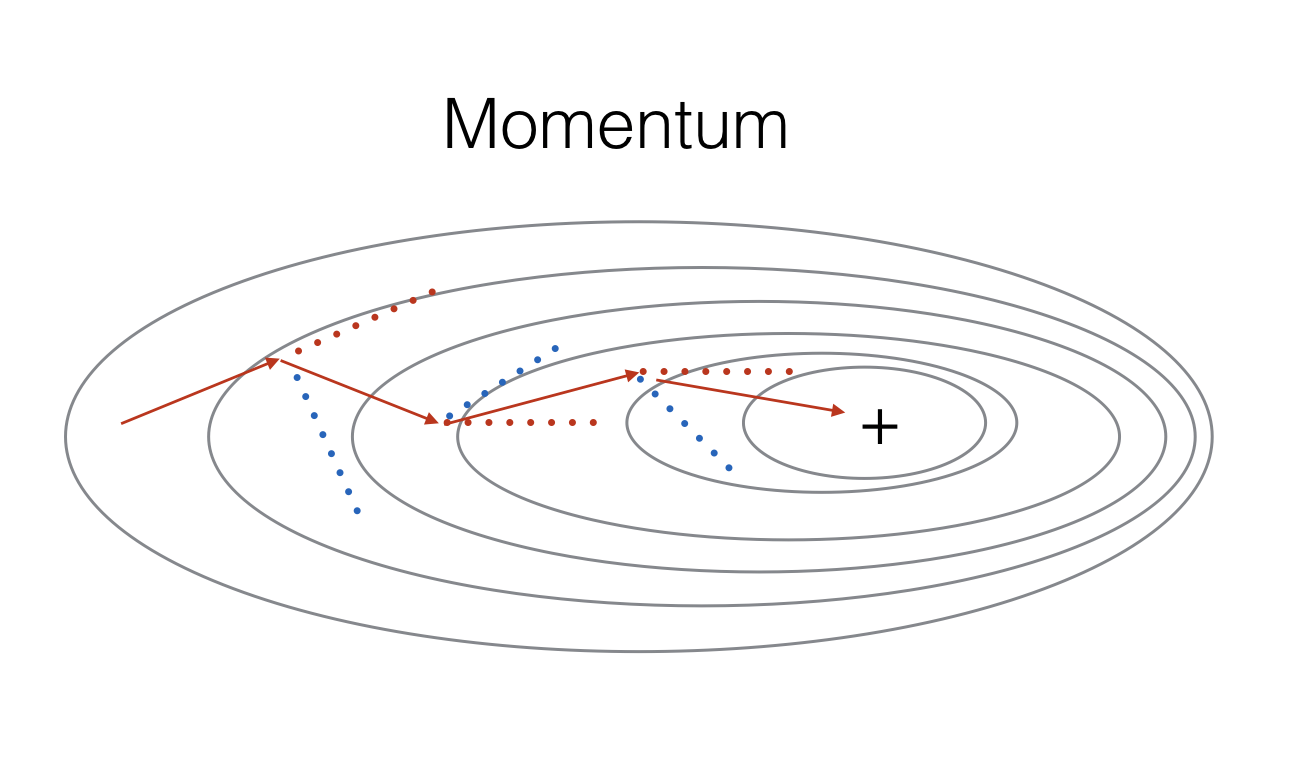


**Exercise**: Initialize the velocity. The velocity $v$ is a python dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the `grads` dictionary, that is:
for $l =1,...,L$:
```python
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
```
**Remark:** The iterator `l` starts at 0 in the for loop, while the first parameters are v["dW1"] and v["db1"] (that's a "one" on the superscript). This is why we are shifting `l` to `l+1` in the for loop.

In [66]:
# GRADED FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        ### END CODE HERE ###
        
    return v

In [67]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = \n", str(v["dW1"]))
print("v[\"db1\"] = \n", str(v["db1"]))
print("v[\"dW2\"] = \n", str(v["dW2"]))
print("v[\"db2\"] = \n", str(v["db2"]))

v["dW1"] = 
 [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
 [[0.]
 [0.]]
v["dW2"] = 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
 [[0.]
 [0.]
 [0.]]


**Expected Output**:

<table style="width:40%"> 
<tr>
<td > **v["dW1"]** </td> 
       <td > [[ 0.  0.  0.]
[ 0.  0.  0.]] </td> 
</tr> 

<tr>
<td > **v["db1"]** </td> 
       <td > [[ 0.]
[ 0.]] </td> 
</tr> 

<tr>
<td > **v["dW2"]** </td> 
       <td > [[ 0.  0.  0.]
[ 0.  0.  0.]
[ 0.  0.  0.]] </td> 
</tr> 

<tr>
<td > **v["db2"]** </td> 
       <td > [[ 0.]
[ 0.]
[ 0.]] </td> 
</tr> 
</table>

In [68]:
np.testing.assert_equal(v["dW1"], [[0., 0., 0.], [0., 0., 0.]])
np.testing.assert_equal(v["db1"], [[0.], [0.]])
np.testing.assert_equal(v["dW2"], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
np.testing.assert_equal(v["db2"], [[0.], [0.], [0.]])

**Exercise**:  Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  

**Remark:** The iterator `l` starts at 0 in the for loop, while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` when coding.

In [73]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1-beta) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1-beta) * grads["db" + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v["db" + str(l+1)]
        ### END CODE HERE ###
        
    return parameters, v

In [74]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n", parameters["W1"])
print("b1 = \n", parameters["b1"])
print("W2 = \n", parameters["W2"])
print("b2 = \n", parameters["b2"])
print("v[\"dW1\"] = \n", v["dW1"])
print("v[\"db1\"] = \n", v["db1"])
print("v[\"dW2\"] = \n", v["dW2"])
print("v[\"db2\"] = \n", v["db2"])

W1 = 
 [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
 [[ 1.74493465]
 [-0.76027113]]
W2 = 
 [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
 [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
 [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
 [[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
 [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
 [[0.02344157]
 [0.16598022]
 [0.07420442]]


**Expected Output**:

<table style="width:90%"> 
<tr>
<td > **W1** </td> 
       <td > [[ 1.62544598 -0.61290114 -0.52907334]
[-1.07347112  0.86450677 -2.30085497]] </td> 
</tr> 

<tr>
<td > **b1** </td> 
       <td > [[ 1.74493465]
[-0.76027113]] </td> 
</tr> 

<tr>
<td > **W2** </td> 
       <td > [[ 0.31930698 -0.24990073  1.4627996 ]
[-2.05974396 -0.32173003 -0.38320915]
[ 1.13444069 -1.0998786  -0.1713109 ]] </td> 
</tr> 

<tr>
<td > **b2** </td> 
       <td > [[-0.87809283]
[ 0.04055394]
[ 0.58207317]] </td> 
</tr> 

<tr>
<td > **v["dW1"]** </td> 
       <td > [[-0.11006192  0.11447237  0.09015907]
[ 0.05024943  0.09008559 -0.06837279]] </td> 
</tr> 

<tr>
<td > **v["db1"]** </td> 
       <td > [[-0.01228902]
[-0.09357694]] </td> 
</tr> 

<tr>
<td > **v["dW2"]** </td> 
       <td > [[-0.02678881  0.05303555 -0.06916608]
[-0.03967535 -0.06871727 -0.08452056]
[-0.06712461 -0.00126646 -0.11173103]] </td> 
</tr> 

<tr>
<td > **v["db2"]** </td> 
       <td > [[ 0.02344157]
[ 0.16598022]
[ 0.07420442]]</td> 
</tr> 
</table>

In [75]:
np.testing.assert_almost_equal(parameters["W1"], [[ 1.62544598, -0.61290114, -0.52907334], 
                                                  [-1.07347112,  0.86450677, -2.30085497]])
np.testing.assert_almost_equal(parameters["b1"], [[ 1.74493465], [-0.76027113]])
np.testing.assert_almost_equal(parameters["W2"], [[ 0.31930698, -0.24990073,  1.4627996],
                                                  [-2.05974396, -0.32173003, -0.38320915],
                                                  [ 1.13444069, -1.0998786,  -0.1713109 ]])
np.testing.assert_almost_equal(parameters["b2"], [[-0.87809283], [ 0.04055394], [ 0.58207317]])
np.testing.assert_almost_equal(v["dW1"], [[-0.11006192,  0.11447237,  0.09015907], 
                                          [ 0.05024943,  0.09008559, -0.06837279]])
np.testing.assert_almost_equal(v["db1"], [[-0.01228902], [-0.09357694]])
np.testing.assert_almost_equal(v["dW2"], [[-0.02678881,  0.05303555, -0.06916608],
                                          [-0.03967535, -0.06871727, -0.08452056],
                                          [-0.06712461, -0.00126646, -0.11173103]])
np.testing.assert_almost_equal(v["db2"], [[ 0.02344157], [ 0.16598022], [ 0.07420442]])

**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

### 2.3 Adam

Adam is one of the most effective optimization algorithms for training neural networks. How does it work?
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  


**Exercise**: Initialize the Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables $v, s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for `grads`, that is:
for $l = 1, ..., L$:
```python
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
s["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
s["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
```

In [76]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
    ### END CODE HERE ###
    
    return v, s

In [77]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n", v["dW1"])
print("v[\"db1\"] = \n", v["db1"])
print("v[\"dW2\"] = \n", v["dW2"])
print("v[\"db2\"] = \n", v["db2"])
print("s[\"dW1\"] = \n", s["dW1"])
print("s[\"db1\"] = \n", s["db1"])
print("s[\"dW2\"] = \n", s["dW2"])
print("s[\"db2\"] = \n", s["db2"])

v["dW1"] = 
 [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
 [[0.]
 [0.]]
v["dW2"] = 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
 [[0.]
 [0.]
 [0.]]
s["dW1"] = 
 [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
 [[0.]
 [0.]]
s["dW2"] = 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = 
 [[0.]
 [0.]
 [0.]]


**Expected Output**:

<table style="width:40%"> 
<tr>
<td > **v["dW1"]** </td> 
       <td > [[ 0.  0.  0.]
[ 0.  0.  0.]] </td> 
</tr> 

<tr>
<td > **v["db1"]** </td> 
       <td > [[ 0.]
[ 0.]] </td> 
</tr> 

<tr>
<td > **v["dW2"]** </td> 
       <td > [[ 0.  0.  0.]
[ 0.  0.  0.]
[ 0.  0.  0.]] </td> 
</tr> 

<tr>
<td > **v["db2"]** </td> 
       <td > [[ 0.]
[ 0.]
[ 0.]] </td> 
</tr> 
<tr>
<td > **s["dW1"]** </td> 
       <td > [[ 0.  0.  0.]
[ 0.  0.  0.]] </td> 
</tr> 

<tr>
<td > **s["db1"]** </td> 
       <td > [[ 0.]
[ 0.]] </td> 
</tr> 

<tr>
<td > **s["dW2"]** </td> 
       <td > [[ 0.  0.  0.]
[ 0.  0.  0.]
[ 0.  0.  0.]] </td> 
</tr> 

<tr>
<td > **s["db2"]** </td> 
       <td > [[ 0.]
[ 0.]
[ 0.]] </td> 
</tr>

</table>

In [78]:
np.testing.assert_equal(v["dW1"], [[0., 0., 0.], [0., 0., 0.]])
np.testing.assert_equal(s["dW1"], [[0., 0., 0.], [0., 0., 0.]])
np.testing.assert_equal(v["db1"], [[0.], [0.]])
np.testing.assert_equal(s["db1"], [[0.], [0.]])
np.testing.assert_equal(v["dW2"], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
np.testing.assert_equal(s["dW2"], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
np.testing.assert_equal(v["db2"], [[0.], [0.], [0.]])
np.testing.assert_equal(s["db2"], [[0.], [0.], [0.]])

**Exercise**:  Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` when coding.

In [105]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]
        ### END CODE HERE ###
        
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)
        ### END CODE HERE ###
        
        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l+1)] = beta2* s["dW" + str(l+1)] + (1-beta2)* (grads["dW" + str(l+1)] * grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2* s["db" + str(l+1)] + (1-beta2)* (grads["db" + str(l+1)] * grads["db" + str(l+1)])
        ### END CODE HERE ###
        
        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**t)
        ### END CODE HERE ###
        
        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
        ### END CODE HERE ###
        
    return parameters, v, s

In [106]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = \n", parameters["W1"])
print("b1 = \n", parameters["b1"])
print("W2 = \n", parameters["W2"])
print("b2 = \n", parameters["b2"])
print("v[\"dW1\"] = \n", v["dW1"])
print("v[\"db1\"] = \n", v["db1"])
print("v[\"dW2\"] = \n", v["dW2"])
print("v[\"db2\"] = \n", v["db2"])
print("s[\"dW1\"] = \n", s["dW1"])
print("s[\"db1\"] = \n", s["db1"])
print("s[\"dW2\"] = \n", s["dW2"])
print("s[\"db2\"] = \n", s["db2"])

W1 = 
 [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = 
 [[ 1.75225313]
 [-0.75376553]]
W2 = 
 [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = 
 [[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = 
 [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
 [[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
 [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
 [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = 
 [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = 
 [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = 
 [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = 
 [[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


**Expected Output**:

<table> 
<tr>
<td > **W1** </td> 
       <td > [[ 1.63178673 -0.61919778 -0.53561312]
[-1.08040999  0.85796626 -2.29409733]] </td> 
</tr> 

<tr>
<td > **b1** </td> 
       <td > [[ 1.75225313]
[-0.75376553]] </td> 
</tr> 

<tr>
<td > **W2** </td> 
       <td > [[ 0.32648046 -0.25681174  1.46954931]
[-2.05269934 -0.31497584 -0.37661299]
[ 1.14121081 -1.09245036 -0.16498684]] </td> 
</tr> 

<tr>
<td > **b2** </td> 
       <td > [[-0.88529978]
[ 0.03477238]
[ 0.57537385]] </td> 
</tr> 
<tr>
<td > **v["dW1"]** </td> 
       <td > [[-0.11006192  0.11447237  0.09015907]
[ 0.05024943  0.09008559 -0.06837279]] </td> 
</tr> 

<tr>
<td > **v["db1"]** </td> 
       <td > [[-0.01228902]
[-0.09357694]] </td> 
</tr> 

<tr>
<td > **v["dW2"]** </td> 
       <td > [[-0.02678881  0.05303555 -0.06916608]
[-0.03967535 -0.06871727 -0.08452056]
[-0.06712461 -0.00126646 -0.11173103]] </td> 
</tr> 

<tr>
<td > **v["db2"]** </td> 
       <td > [[ 0.02344157]
[ 0.16598022]
[ 0.07420442]] </td> 
</tr> 
<tr>
<td > **s["dW1"]** </td> 
       <td > [[ 0.00121136  0.00131039  0.00081287]
[ 0.0002525   0.00081154  0.00046748]] </td> 
</tr> 

<tr>
<td > **s["db1"]** </td> 
       <td > [[  1.51020075e-05]
[  8.75664434e-04]] </td> 
</tr> 

<tr>
<td > **s["dW2"]** </td> 
       <td > [[  7.17640232e-05   2.81276921e-04   4.78394595e-04]
[  1.57413361e-04   4.72206320e-04   7.14372576e-04]
[  4.50571368e-04   1.60392066e-07   1.24838242e-03]] </td> 
</tr> 

<tr>
<td > **s["db2"]** </td> 
       <td > [[  5.49507194e-05]
[  2.75494327e-03]
[  5.50629536e-04]] </td> 
</tr>
</table>

In [107]:
np.testing.assert_almost_equal(parameters["W1"], [[ 1.63178673, -0.61919778, -0.53561312],
                                                  [-1.08040999,  0.85796626, -2.29409733]])
np.testing.assert_almost_equal(parameters["b1"], [[ 1.75225313], [-0.75376553]])
np.testing.assert_almost_equal(parameters["W2"], [[ 0.32648046, -0.25681174, 1.46954931],
                                                  [-2.05269934, -0.31497584, -0.37661299],
                                                  [ 1.14121081, -1.0924499, -0.16498684]])
np.testing.assert_almost_equal(parameters["b2"], [[-0.88529978], [ 0.03477238], [ 0.57537385]])

np.testing.assert_almost_equal(v["dW1"], [[-0.11006192,  0.11447237,  0.09015907],
                                          [ 0.05024943,  0.09008559, -0.06837279]])
np.testing.assert_almost_equal(v["db1"], [[-0.01228902], [-0.09357694]])
np.testing.assert_almost_equal(v["dW2"], [[-0.02678881,  0.05303555, -0.06916608],
                                          [-0.03967535, -0.06871727, -0.08452056],
                                          [-0.06712461, -0.00126646, -0.11173103]])
np.testing.assert_almost_equal(v["db2"], [[ 0.02344157], [ 0.16598022], [ 0.07420442]])

np.testing.assert_almost_equal(s["dW1"], [[ 0.00121136,  0.00131039,  0.00081287],
                                          [ 0.0002525,   0.00081154,  0.00046748]])
np.testing.assert_almost_equal(s["db1"], [[  1.51020075e-05], [  8.75664434e-04]])
np.testing.assert_almost_equal(s["dW2"], [[  7.17640232e-05,   2.81276921e-04,   4.78394595e-04],
                                          [  1.57413361e-04,   4.72206320e-04,   7.14372576e-04],
                                          [  4.50571368e-04,   1.60392066e-07,   1.24838242e-03]])
np.testing.assert_almost_equal(s["db2"], [[  5.49507194e-05], [  2.75494327e-03], [  5.50629536e-04]])

### 2.4 Stochastic optimization

Stochastic optimization refers to a variant of gradient descent. The update rules that you have just implemented do not change. What change is that you would be computing gradients on just few training examples at a time, rather than on the whole training set. 

Now, let's learn how to build mini-batches from the training set (X, Y). There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

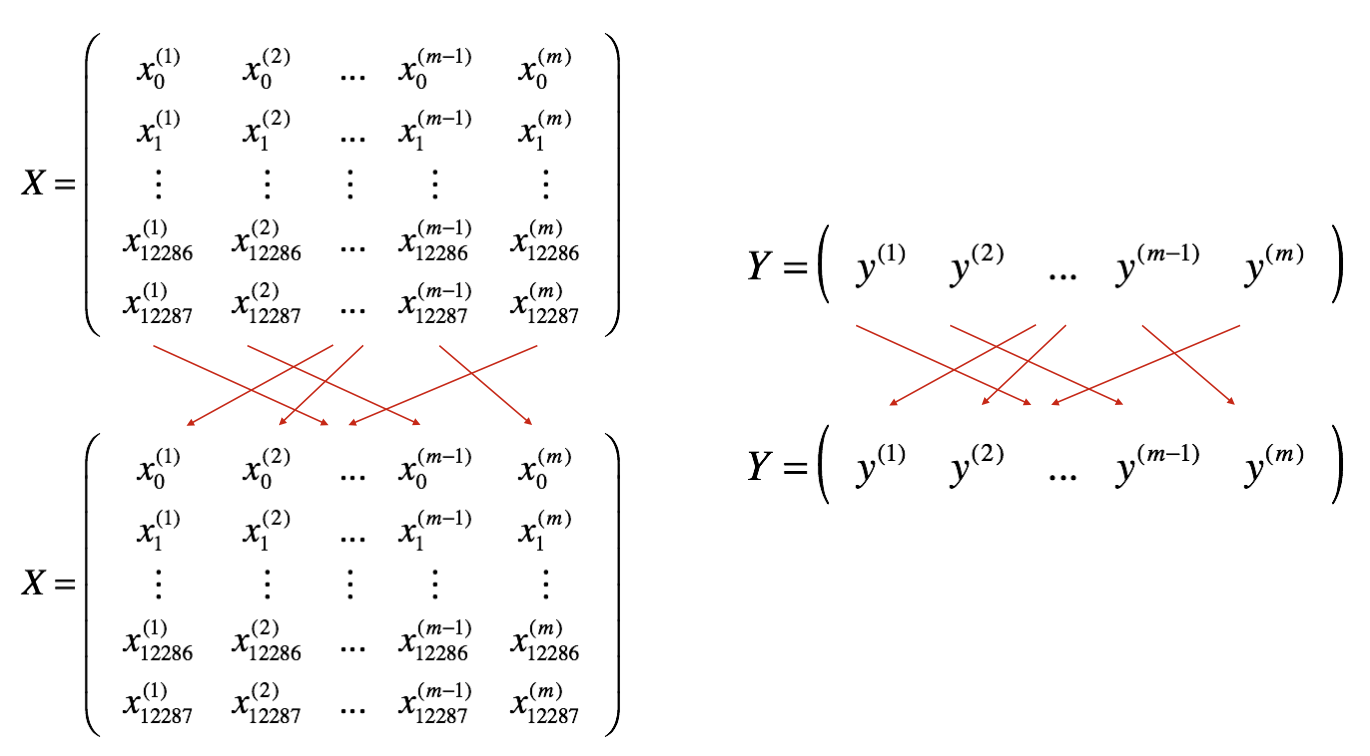

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

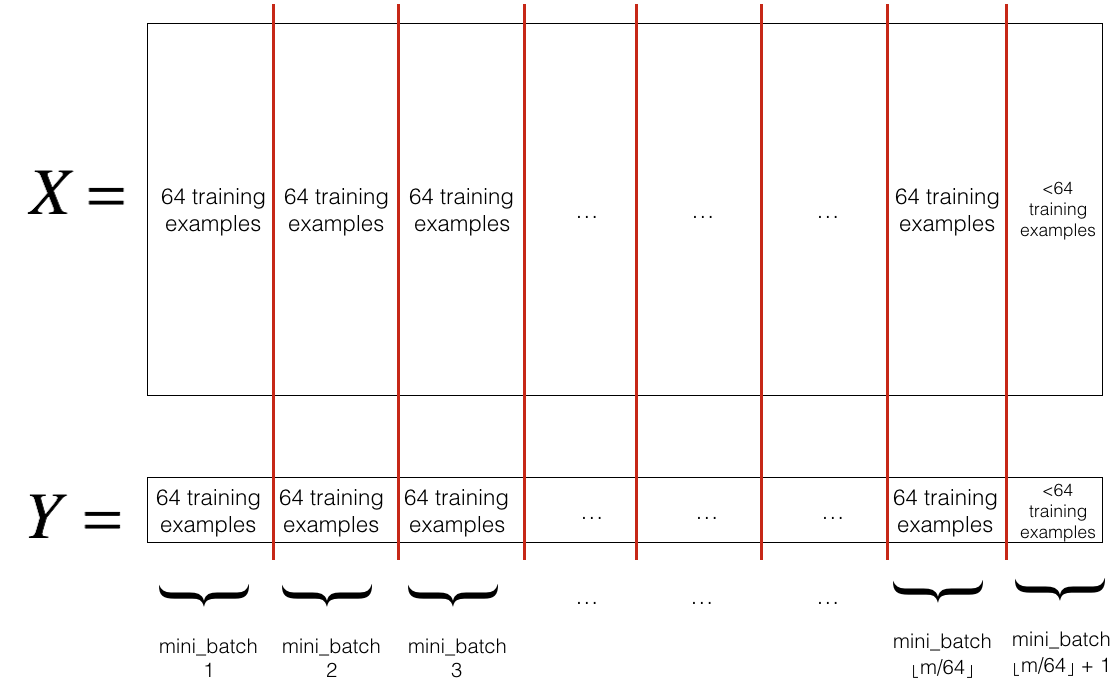

**Exercise**: Implement `random_mini_batches`. We coded the shuffling part for you. To help you with the partitioning step, we give you the following code that selects the indexes for the $1^{st}$ and $2^{nd}$ mini-batches:
```python
first_mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
second_mini_batch_X = shuffled_X[:, mini_batch_size : 2 * mini_batch_size]
...
```

Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\lfloor \frac{m}{mini\_batch\_size}\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be ($m-mini_\_batch_\_size \times \lfloor \frac{m}{mini\_batch\_size}\rfloor$). 

In [109]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size) 
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        ### END CODE HERE ###
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X =  shuffled_X[:, (k + 1) * mini_batch_size:]
        mini_batch_Y =  shuffled_Y[:, (k + 1) * mini_batch_size:]
        ### END CODE HERE ###
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [110]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


**Expected Output**:

<table style="width:50%"> 
<tr>
<td > **shape of the 1st mini_batch_X** </td> 
       <td > (12288, 64) </td> 
</tr> 

<tr>
<td > **shape of the 2nd mini_batch_X** </td> 
       <td > (12288, 64) </td> 
</tr> 

<tr>
<td > **shape of the 3rd mini_batch_X** </td> 
       <td > (12288, 20) </td> 
</tr>
<tr>
<td > **shape of the 1st mini_batch_Y** </td> 
       <td > (1, 64) </td> 
</tr> 
<tr>
<td > **shape of the 2nd mini_batch_Y** </td> 
       <td > (1, 64) </td> 
</tr> 
<tr>
<td > **shape of the 3rd mini_batch_Y** </td> 
       <td > (1, 20) </td> 
</tr> 
<tr>
<td > **mini batch sanity check** </td> 
       <td > [ 0.90085595 -0.7612069   0.2344157 ] </td> 
</tr>

</table>

In [111]:
np.testing.assert_equal(mini_batches[0][0].shape, (12288,64))
np.testing.assert_equal(mini_batches[1][0].shape, (12288,64))
np.testing.assert_equal(mini_batches[2][0].shape, (12288,20))
np.testing.assert_equal(mini_batches[0][1].shape, (1,64))
np.testing.assert_equal(mini_batches[1][1].shape, (1,64))
np.testing.assert_equal(mini_batches[2][1].shape, (1,20))

np.testing.assert_almost_equal(mini_batches[0][0][0][0:3], [0.90085595, -0.7612069, 0.2344157])

### 2.5 Model with different optimization algorithms

You now have three working optimization algorithms (gradient descent, Momentum, Adam). Let's implement a model with each of these optimizers and observe the difference. You will use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.)

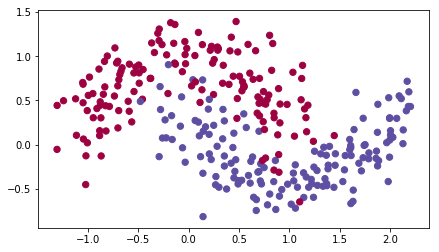

In [112]:
train_X, train_Y = load_dataset()

We have already implemented a 3-layer neural network. You will train it with: 
- Mini-batch **Gradient Descent**: it will call your function:
    - `update_parameters_with_gd()`
- Mini-batch **Momentum**: it will call your functions:
    - `initialize_velocity()` and `update_parameters_with_momentum()`
- Mini-batch **Adam**: it will call your functions:
    - `initialize_adam()` and `update_parameters_with_adam()`

In [113]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

#### 2.5.1 - Mini-batch gradient descent

Run the following code to see how the model does with mini-batch gradient descent.

Cost after epoch 0: 0.691989
Cost after epoch 1000: 0.687526
Cost after epoch 2000: 0.669339
Cost after epoch 3000: 0.650285
Cost after epoch 4000: 0.607519
Cost after epoch 5000: 0.594429
Cost after epoch 6000: 0.510829
Cost after epoch 7000: 0.417701
Cost after epoch 8000: 0.373228
Cost after epoch 9000: 0.467210


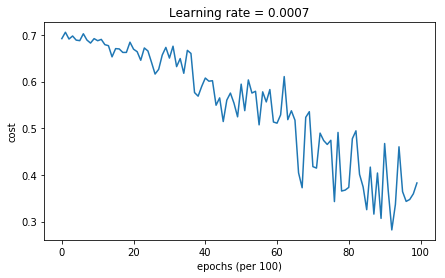

Accuracy: 0.8533333333333334


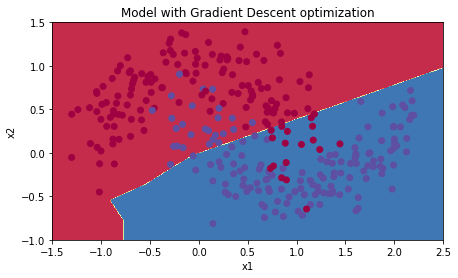

In [114]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 2.5.2 Mini-batch gradient descent with momentum

Run the following code to see how the model does with momentum. Because this example is relatively simple, the gains from using momemtum are small; but for more complex problems you might see bigger gains.

Cost after epoch 0: 0.691993
Cost after epoch 1000: 0.687558
Cost after epoch 2000: 0.669377
Cost after epoch 3000: 0.650371
Cost after epoch 4000: 0.607684
Cost after epoch 5000: 0.594663
Cost after epoch 6000: 0.511190
Cost after epoch 7000: 0.418239
Cost after epoch 8000: 0.373525
Cost after epoch 9000: 0.467329


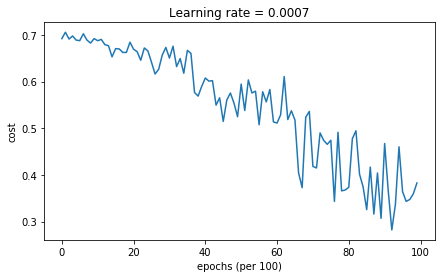

Accuracy: 0.8533333333333334


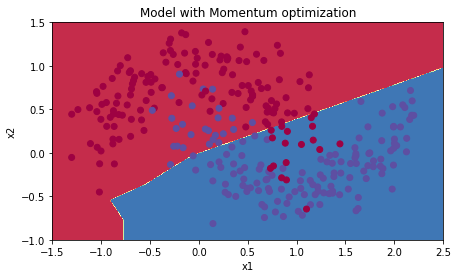

In [115]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 2.5.3 - Mini-batch with Adam

Run the following code to see how the model does with Adam.

Cost after epoch 0: 0.691852
Cost after epoch 1000: 0.184766
Cost after epoch 2000: 0.143045
Cost after epoch 3000: 0.078972
Cost after epoch 4000: 0.123409
Cost after epoch 5000: 0.095133
Cost after epoch 6000: 0.090001
Cost after epoch 7000: 0.030284
Cost after epoch 8000: 0.120698
Cost after epoch 9000: 0.201708


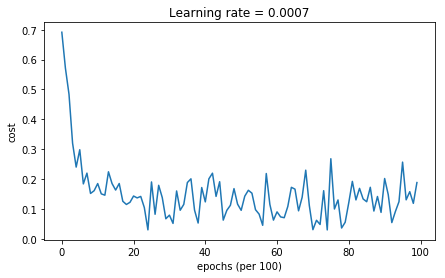

Accuracy: 0.9433333333333334


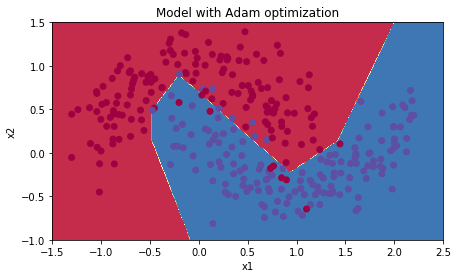

In [116]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 2.5.4 - Summary

<table> 
<tr>
    <td>
    **optimization method**
    </td>
    <td>
    **accuracy**
    </td>
    <td>
    **cost shape**
    </td>

</tr>
    <td>
    Gradient descent
    </td>
    <td>
    79.7%
    </td>
    <td>
    oscillations
    </td>
<tr>
    <td>
    Momentum
    </td>
    <td>
    79.7%
    </td>
    <td>
    oscillations
    </td>
</tr>
<tr>
    <td>
    Adam
    </td>
    <td>
    94%
    </td>
    <td>
    smoother
    </td>
</tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

**Credits:** 
- This assignment is partly based on Andrew Ng's course on Coursera.